In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# import tensorflow as tf
from xgboost import XGBRegressor, XGBRFRegressor
import warnings

warnings.filterwarnings("ignore")

In [40]:
def load_ff3(val_start_date=None):
    ff3 = pd.read_csv('ff3_daily.csv')
    
    if val_start_date is not None:
        ff3 = ff3[ff3['date'] >= val_start_date]
        
    ff3 = ff3.reset_index(drop=True)
    ff3.index = ff3['date']
    ff3 = ff3.drop(columns=['date'])
    
    return ff3

def set_seed(seed_value):
    # Adding a fixed seed from this solution: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    # tf.compat.v1.set_random_seed(seed_value)
    torch.manual_seed(seed_value)
    return

def io_day_n_lag(data, n):
    # for each column in data, create five lags
    y = data.iloc[n:,:].reset_index(drop=True)    
    
    X = pd.DataFrame()

    for i in range(1, n+1):
        temp = data.shift(i).reset_index(drop=True)
        temp.columns = [f'{col}_lag{i}' for col in temp.columns]
        X = pd.concat([X, temp], axis=1)
    
    X = X.iloc[n:,:].reset_index(drop=True)
    
    return X, y

# def io_day_1_lag_second_order_input(data):
#     # Create input output pairs where input data includes second order interactions
#     X, y = io_day_1_lag(data)
#     cols = X.columns

#     for i in range(len(cols)):
#         for j in range(i+1, len(cols)):
#             col_name = cols[i] + cols[j]
#             col_values = X[cols[i]] * X[cols[j]]
#             X[col_name] = col_values
#     return X, y

def predictions_to_returns(pred_df, y, weighted=True):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions (in form [0, 1, 0, 0, 0])
    if weighted:
        strat_df = pred_df.apply(lambda row : weighted_predicted_factor_strat(row), axis = 1)
    else:
        strat_df = pred_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector

def weighted_predicted_factor_strat(row):
    pos_preds = [x for x in row if x > 0]
    neg_preds = [x for x in row if x < 0]
    pos_sum = sum(pos_preds)
    neg_sum = sum(neg_preds)
    row_list = [0]*len(row)
    for i in range(len(row)):
        if row[i] > 0:
            row_list[i] = row[i] / pos_sum
        elif row[i] < 0:
            row_list[i] = row[i] / neg_sum
    return pd.Series(row_list)
    

def max_predicted_factor_strat(row):
    # For each day, set our strategy to be the factor with
    # the highest predicted return
    max_pred_return = max(row)
    row_list = [x == max_pred_return for x in row]
    return pd.Series(row_list)

In [41]:
class MultiLayerLSTM(nn.Module):
    def __init__(self, input_size, output_size, params=None):
        super(MultiLayerLSTM, self).__init__()
        
        self.hidden_sizes = params["hidden_sizes"] if params and "hidden_sizes" in params else [50]
        self.dropout = params["dropout"] if params and "dropout" in params else 0
        self.activation_fn = params["activation_fn"] if params and "activation_fn" in params else nn.ReLU()
        
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_size, self.hidden_sizes[0], dropout=self.dropout, bidirectional=True, batch_first=True))
        
        for i in range(1, len(self.hidden_sizes)):
            self.lstm_layers.append(nn.LSTM(self.hidden_sizes[i-1] * 2, self.hidden_sizes[i], dropout=self.dropout, bidirectional=True, batch_first=True))
            
        self.output_layer = nn.Linear(self.hidden_sizes[-1] * 2, output_size)
    
    def forward(self, x):
        h_t = x
        for lstm_layer in self.lstm_layers:
            h_t, _ = lstm_layer(h_t)
            h_t = h_t[:, -1, :]
            h_t = self.activation_fn(h_t)
        
        # Only use the output of the last LSTM layer
        out = self.output_layer(h_t)
        return out

In [42]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, output_size, params=None):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.hidden_size = params["hidden_size"] if params and "hidden_size" in params else 50
        self.num_layers = params["num_layers"] if params and "num_layers" in params else 1
        self.dropout = params["dropout"] if params and "dropout" in params else 0
        self.activation_fn = params["activation_fn"] if params and "activation_fn" in params else nn.ReLU()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc_linear =  nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.activation_fn(hn)
        out = self.fc_linear(out)
        return out

In [43]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleFeedForwardNN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.hidden_layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        print(f"number of hidden layers: {len(hidden_sizes)}")
    def forward(self, x):
        for layer in self.hidden_layers:
            x = nn.functional.relu(layer(x))
        x = self.output_layer(x)
        return x

In [44]:
def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, lr, batch_size, weighting_type, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "lr": lr,
        "batch_size": batch_size,
        "weighting_type": weighting_type
    }
    try:
        torch.save(checkpoint, path)
        print(f"Checkpoint saved at {path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
    
def load_checkpoint_from_path(path, input_size, output_size, model_type=SimpleLSTM, model_params=None):
    print(f"Loading checkpoint from {path}.pt")\
            
    checkpoint = torch.load(path)
    model = model_type(input_size, output_size, params=model_params)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=checkpoint['lr'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    
    print(f"Checkpoint loaded. ")
    
    return model, optimizer, train_losses, val_losses

def load_model_LSTM(path):
    final_save = torch.load(path)
    
    model_state_dict = final_save["model_state_dict"]
    model_params = final_save["model_params"]
    model_type = final_save["model_type"]
    input_size = final_save["input_size"]
    output_size = final_save["output_size"]
    
    model = model_type(input_size, output_size, params=model_params)
    model.load_state_dict(model_state_dict)
    
    return model

def load_model_xgb(path):
    final_save = torch.load(path)
    
    model = final_save['model']
    
    return model

In [45]:
def train_model_LSTM(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        num_epochs=50, 
        batch_size=32, 
        logging=True, 
        save_epochs=None, 
        final_save_path=None,
        checkpoints_dir=None, 
        load_checkpoint=None,
        model_params=None,
        model_type=SimpleLSTM):
    if (save_epochs and not checkpoints_dir) or (checkpoints_dir and not save_epochs):
        raise ValueError("Both save_epochs and checkpoints_dir must be provided if one is provided")
    elif checkpoints_dir:
        os.makedirs(checkpoints_dir, exist_ok=True)
    
    # Prapare datasets
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Calculate weights for each datapoint (closer to the end of the dataset, the more weight it has)
    def calc_weights():
        weights = torch.ones(len(y_train))
        for i in range(len(y_train)):
            weights[i] += 0.5 * (i / len(y_train))**2
        weights = weights / weights.sum()
        return weights
    # weights = calc_weights()
    weights = torch.ones(len(y_train))
    
    # model = Sequential()
    # model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dense(16, activation='relu'))
    # model.add(Dense(6, activation='linear'))
    # model.compile(loss='mean_squared_error', optimizer='adam')
    # model.fit(X_train, y_train, batch_size=32, epochs=50,
    #           validation_data=(X_val, y_val), verbose=2)
    
    # Define LSTM model
    input_size = X_train.shape[-1]  # Number of features
    output_size = y_train.shape[-1]  # Number of output features
    start_epoch = 1
    if load_checkpoint and checkpoints_dir:
        model, optimizer, train_losses, val_losses = load_checkpoint_from_path(checkpoints_dir+f'/epoch{load_checkpoint}.pt', input_size, output_size, model_params=model_params)
        
    elif load_checkpoint and not checkpoints_dir:
        raise ValueError("If load_checkpoint is provided, checkpoints_dir must also be provided")
    else:
        model = model_type(input_size, output_size, params=model_params)
        
        # Loss and optimizer
        lr = 1e-3
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
        train_losses = []
        val_losses = []
    
    loss_fn = nn.MSELoss()
        
    for epoch in range(start_epoch, num_epochs+1):
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            # loss = (loss * weights).mean()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = model(X_val_batch)
                loss = loss_fn(val_outputs, y_val_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        if logging:
            print(f'Epoch [{epoch}/{num_epochs}]')
            print(f'\tTraining Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        elif save_epochs and epoch % save_epochs == 0 and not logging:
            print(f'Epoch [{epoch}/{num_epochs}]')
            print(f'\tTraining Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        if save_epochs and epoch % save_epochs == 0:
            weighting_type = 'equal'
            save_checkpoint(model, optimizer, epoch, train_losses, val_losses, lr, batch_size, weighting_type, f'{checkpoints_dir}/epoch{epoch}.pt')
        
        print()
    
    if final_save_path:
        final_save = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "lr": lr,
            "batch_size": batch_size,
            "weighting_type": 'equal',
            "model_params": model_params,
            "model_type": model_type,
            "input_size": input_size,
            "output_size": output_size,
            "num_epochs": num_epochs
        }
        torch.save(final_save, final_save_path)
    
    return model

In [46]:
def train_model_xgb(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        final_save_path=None, 
        model_type=XGBRegressor):
    
    model = model_type(objective='reg:squarederror', device='cuda')
    model.fit(X_train, y_train)
    
    print(f"Train MSE: {mean_squared_error(y_train, model.predict(X_train))}")
    print(f"Validation MSE: {mean_squared_error(y_val, model.predict(X_val))}")
    
    if final_save_path:
        final_save = {
            "model": model
        }
        torch.save(final_save, final_save_path)
    
    return model

In [47]:
def preprocess_data_LSTM(data, io_fn, seq_len, test_size_split=0.2):
    X, y = io_fn(data, seq_len)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size_split, shuffle=False)
    
    X_train = X_train.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_train = y_train.drop(columns=['date'])
    X_val = X_val.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_val = y_val.drop(columns=['date'])
    
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    y_train = y_train.apply(pd.to_numeric, errors='coerce')
    X_val = X_val.apply(pd.to_numeric, errors='coerce')
    y_val = y_val.apply(pd.to_numeric, errors='coerce')
    
    # Convert X_train of shape (n_samples, n_features) to (n_samples, seq_len, n_features)
    X_train = X_train.values.reshape(X_train.shape[0], seq_len, X_train.shape[1] // seq_len)[:, ::-1, :]
    y_train = y_train.values
    X_val = X_val.values.reshape(X_val.shape[0], seq_len, X_val.shape[1] // seq_len)[:, ::-1, :]
    y_val = y_val.values
    
    X_train = np.ascontiguousarray(X_train)
    X_val = np.ascontiguousarray(X_val)
    
    val_start_date = int(data.iloc[len(X_train)+seq_len]['date'])
    
    return X_train, y_train, X_val, y_val, val_start_date

def preprocess_data_xgb(data, io_fn, seq_len, test_size_split=0.2):
    X, y = io_fn(data, seq_len)
    print(len(X), len(y))
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size_split, shuffle=False)
    
    X_train = X_train.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_train = y_train.drop(columns=['date'])
    X_val = X_val.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_val = y_val.drop(columns=['date'])
    
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    y_train = y_train.apply(pd.to_numeric, errors='coerce')
    X_val = X_val.apply(pd.to_numeric, errors='coerce')
    y_val = y_val.apply(pd.to_numeric, errors='coerce')
    
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values
    
    val_start_date = int(data.iloc[len(X_train)+seq_len]['date'])
    
    return X_train, y_train, X_val, y_val, val_start_date

In [186]:
DATA_WEIGHING = "value"
NUM_INDUSTRIES = 49

def get_data(num_industries=49, weight_type='value'):
    all_data_paths = {
        "ff3": "ff3_daily.csv",
        "ff6": "ff6_daily.csv"
    }

    for n_ind in [5, 10, 12, 17, 30, 38, 48, 49]:
        for weight in ['equal', 'value']:
            all_data_paths[f"{n_ind}industries_{weight}"] = f"ff_industry_portfolios_daily_{weight}/{n_ind}_Industry_Portfolios_Daily.csv"

    seed = 519
    io_fn = io_day_n_lag
    seq_len = 5

    data_path = all_data_paths[f'{num_industries}industries_{weight_type}']
    # data_path = all_data_paths[f'ff6']

    data = pd.read_csv(data_path)
    data = data.dropna()

    if seed is not None:
        set_seed(seed)

    return data, io_fn, seq_len, all_data_paths

In [187]:
data, io_fn, seq_len, all_data_paths = get_data(NUM_INDUSTRIES, weight_type=DATA_WEIGHING)

In [188]:
X_train_LSTM, y_train, X_val_LSTM, y_val, val_start_date = preprocess_data_LSTM(data, io_fn, seq_len)
print("X_train shape:\t", X_train_LSTM.shape)
print("y_train shape:\t", y_train.shape)
print("X_val shape:\t", X_val_LSTM.shape)
print("y_val shape:\t", y_val.shape)
print("val_start_date:\t", val_start_date)

X_train shape:	 (20564, 5, 49)
y_train shape:	 (20564, 49)
X_val shape:	 (5141, 5, 49)
y_val shape:	 (5141, 49)
val_start_date:	 20031024


In [189]:
X_train_xgb, y_train, X_val_xgb, y_val, val_start_date = preprocess_data_xgb(data, io_fn, seq_len)
print("X_train shape:\t", X_train_xgb.shape)
print("y_train shape:\t", y_train.shape)
print("X_val shape:\t", X_val_xgb.shape)
print( "y_val shape:\t", y_val.shape)
print("val_start_date:\t", val_start_date)

25705 25705
X_train shape:	 (20564, 245)
y_train shape:	 (20564, 49)
X_val shape:	 (5141, 245)
y_val shape:	 (5141, 49)
val_start_date:	 20031024


In [190]:
lstm = train_model_LSTM(
    X_train_LSTM, 
    y_train, 
    X_val_LSTM, 
    y_val, 
    num_epochs=10, 
    batch_size=32, 
    logging=False, 
    save_epochs=10, 
    checkpoints_dir=f'checkpoints/LSTM_1layer_5day_{NUM_INDUSTRIES}industries_{DATA_WEIGHING}',
    final_save_path=f'models/LSTM_1layer_5day_10epochs_{NUM_INDUSTRIES}industries_{DATA_WEIGHING}.pt',
    model_params={
        "hidden_sizes": [50],
        "dropout": 0.1,
        "activation_fn": nn.ReLU()
    },
    model_type=SimpleLSTM)

100%|██████████| 643/643 [00:00<00:00, 667.80it/s]


100%|██████████| 643/643 [00:00<00:00, 689.10it/s]


100%|██████████| 643/643 [00:00<00:00, 670.38it/s]


100%|██████████| 643/643 [00:01<00:00, 633.84it/s]


100%|██████████| 643/643 [00:00<00:00, 644.19it/s]


100%|██████████| 643/643 [00:00<00:00, 667.20it/s]


100%|██████████| 643/643 [00:01<00:00, 624.84it/s]


100%|██████████| 643/643 [00:01<00:00, 597.71it/s]


100%|██████████| 643/643 [00:00<00:00, 648.31it/s]


100%|██████████| 643/643 [00:01<00:00, 638.12it/s]


Epoch [10/10]
	Training Loss: 31.3987, Validation Loss: 2.8306
Checkpoint saved at checkpoints/LSTM_1layer_5day_49industries_value/epoch10.pt



In [89]:
xgb = train_model_xgb(
    X_train_xgb, 
    y_train, 
    X_val_xgb, 
    y_val, 
    final_save_path=f'models/xgb_5day_{NUM_INDUSTRIES}industries_{DATA_WEIGHING}.pt',
    model_type=XGBRegressor)

Train MSE: 0.28657759117232323
Validation MSE: 2.784160202241998


In [99]:
def predict_LSTM(model, X_val):
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(np.zeros((X_val.shape[0], X_val.shape[-1])), dtype=torch.float32)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32)

    with torch.no_grad():
        pred_df = torch.tensor([])
        for X_val_batch, _ in val_loader:
            val_outputs = model(X_val_batch)
            
            pred_df = torch.cat((pred_df, val_outputs), 0)
            
        pred_df = pd.DataFrame(pred_df.numpy())

    return pred_df

def predict_xgboost(model, X_val):
    return pd.DataFrame(model.predict(X_val))

def evaluate_model_LSTM(save_path, data_path, print_summary=True):
    data = pd.read_csv(data_path)
    data = data.dropna()
    
    _, _, X_val, y_val, val_start_date = preprocess_data_LSTM(data, io_fn, seq_len)
    
    model = load_model_LSTM(save_path)
    pred_df = predict_LSTM(model, X_val)
    
    strat_df, strat_ret_vec = predictions_to_returns(pred_df, y_val)

    ff3 = load_ff3(val_start_date)
    strat_ret_vec.index = ff3.index

    # Calculate alpha
    y_ols = sm.add_constant(ff3[['Mkt-RF','SMB', 'HML']])
    model_OLS = sm.OLS(strat_ret_vec, y_ols).fit()
    if print_summary:
        print(model_OLS.summary())
    
    mkt_ret_vec = ff3['Mkt-RF']
    
    return strat_ret_vec, mkt_ret_vec

def evaluate_model_xgb(save_path, data_path, print_summary=True):
    data = pd.read_csv(data_path)
    data = data.dropna()
    
    _, _, X_val, y_val, val_start_date = preprocess_data_xgb(data, io_fn, seq_len)
    
    model = load_model_xgb(save_path)
    pred_df = predict_xgboost(model, X_val)
    
    strat_df, strat_ret_vec = predictions_to_returns(pred_df, y_val)

    ff3 = load_ff3(val_start_date)
    strat_ret_vec.index = ff3.index

    # Calculate alpha
    y_ols = sm.add_constant(ff3[['Mkt-RF','SMB', 'HML']])
    model_OLS = sm.OLS(strat_ret_vec, y_ols).fit()
    if print_summary:
        print(model_OLS.summary())
    
    strat_ret_vec = strat_ret_vec + ff3['RF']
    mkt_ret_vec = ff3['Mkt-RF'] + ff3['RF']
    
    return strat_ret_vec, mkt_ret_vec

def show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='Strategy', log_scale=False):
    cum_strat_rets = (1 + strat_ret_vec/100).cumprod()
    cum_mkt_rets = (1 + mkt_ret_vec/100).cumprod()
    
    cum_mkt_rets.index = pd.to_datetime(cum_mkt_rets.index, format='%Y%m%d')
    cum_mkt_rets_monthly = cum_mkt_rets.resample('M').last()

    cum_strat_rets.index = pd.to_datetime(cum_strat_rets.index, format='%Y%m%d')
    cum_strat_rets_monthly = cum_strat_rets.resample('M').last()
    
    # Plot the cumulative returns
    plt.plot(cum_strat_rets_monthly, label=strategy_name)
    plt.plot(cum_mkt_rets_monthly, label='Market')

    if log_scale:
        plt.yscale('log')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     182.2
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.10e-108
Time:                        03:13:33   Log-Likelihood:                -3880.2
No. Observations:                3057   AIC:                             7768.
Df Residuals:                    3053   BIC:                             7793.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0333      0.016      2.134      0.0

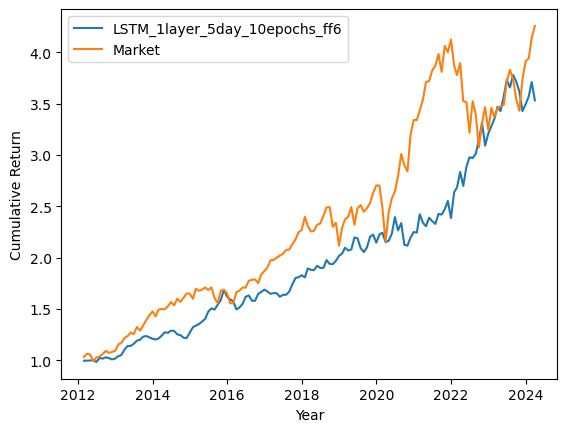

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     195.6
Date:                Wed, 29 May 2024   Prob (F-statistic):          4.80e-116
Time:                        03:13:33   Log-Likelihood:                -3768.4
No. Observations:                3057   AIC:                             7545.
Df Residuals:                    3053   BIC:                             7569.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0326      0.015      2.168      0.0

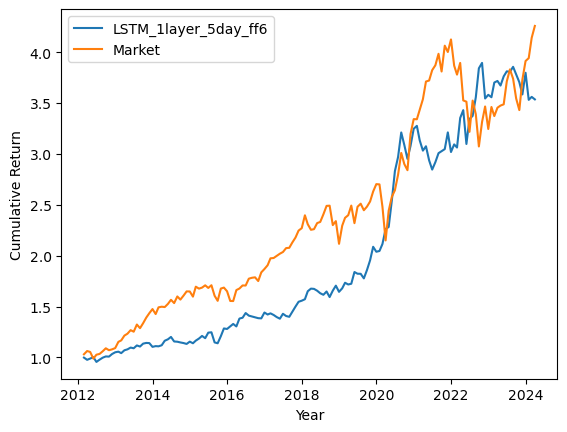

In [175]:
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_10epochs_ff6.pt', all_data_paths['ff6'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_10epochs_ff6', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_ff6.pt', all_data_paths['ff6'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_ff6', log_scale=False)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     2834.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:15:30   Log-Likelihood:                -6977.4
No. Observations:                5141   AIC:                         1.396e+04
Df Residuals:                    5137   BIC:                         1.399e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0117      0.013      0.888      0.3

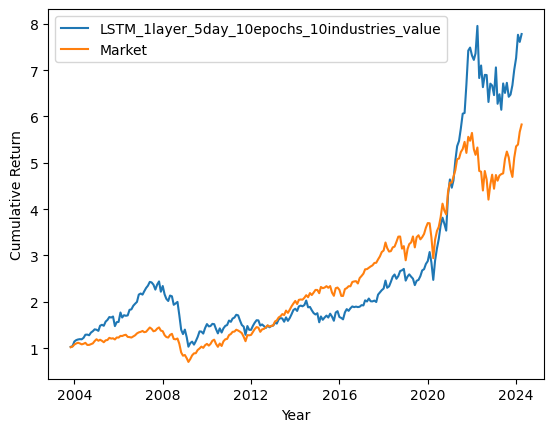

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2861.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:15:30   Log-Likelihood:                -6940.5
No. Observations:                5141   AIC:                         1.389e+04
Df Residuals:                    5137   BIC:                         1.392e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0216      0.013      1.657      0.0

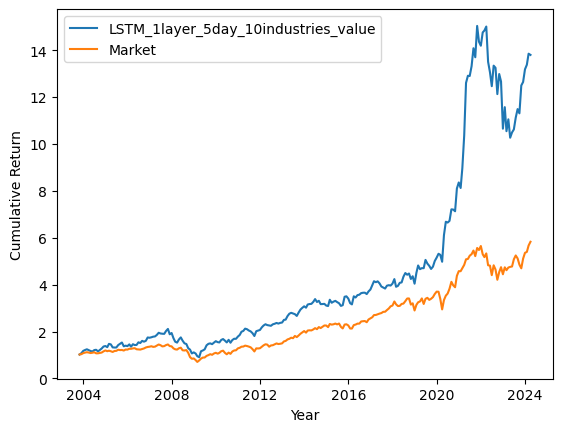

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     2381.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:15:31   Log-Likelihood:                -8072.2
No. Observations:                5141   AIC:                         1.615e+04
Df Residuals:                    5137   BIC:                         1.618e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0651      0.016      4.011      0.0

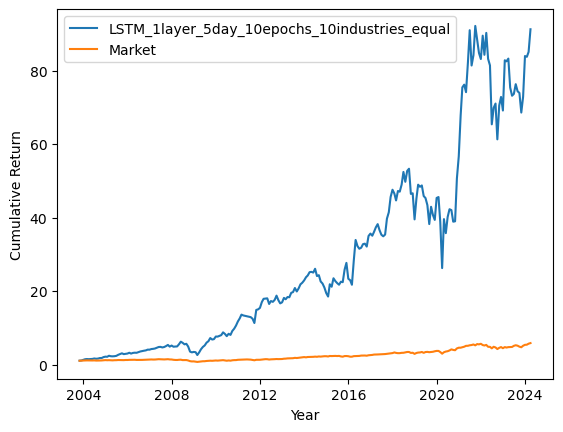

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     2481.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:15:32   Log-Likelihood:                -7981.3
No. Observations:                5141   AIC:                         1.597e+04
Df Residuals:                    5137   BIC:                         1.600e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.016      1.307      0.1

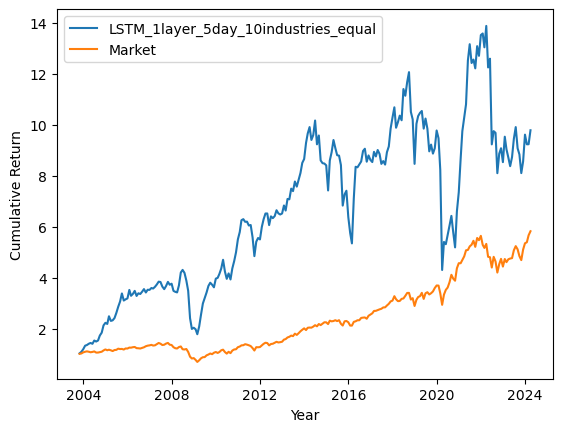

In [180]:
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_10epochs_10industries_value.pt', all_data_paths['10industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_10epochs_10industries_value', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_10industries_value.pt', all_data_paths['10industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_10industries_value', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_10epochs_10industries_equal.pt', all_data_paths['10industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_10epochs_10industries_equal', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_10industries_equal.pt', all_data_paths['10industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_10industries_equal', log_scale=False)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     1510.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:17:54   Log-Likelihood:                -8543.2
No. Observations:                5141   AIC:                         1.709e+04
Df Residuals:                    5137   BIC:                         1.712e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0394      0.018      2.213      0.0

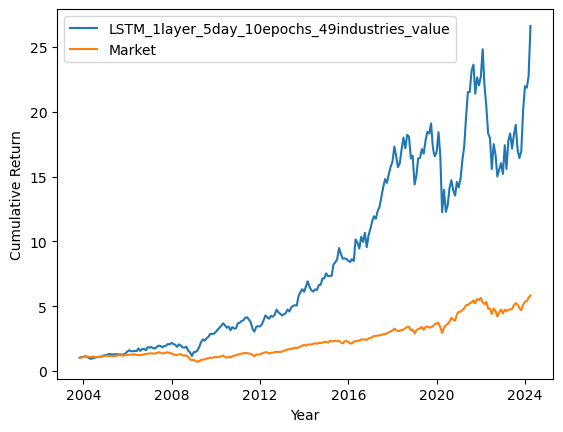

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     1103.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:17:55   Log-Likelihood:                -8840.3
No. Observations:                5141   AIC:                         1.769e+04
Df Residuals:                    5137   BIC:                         1.771e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0140      0.019      0.741      0.4

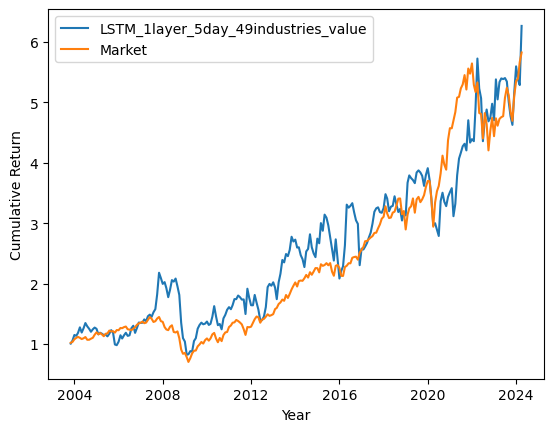

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     1431.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:17:56   Log-Likelihood:                -8938.7
No. Observations:                5141   AIC:                         1.789e+04
Df Residuals:                    5137   BIC:                         1.791e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.019      1.365      0.1

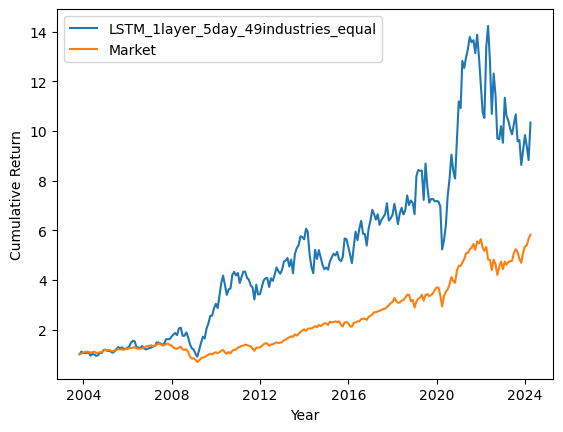

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     1431.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        03:17:57   Log-Likelihood:                -8938.7
No. Observations:                5141   AIC:                         1.789e+04
Df Residuals:                    5137   BIC:                         1.791e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.019      1.365      0.1

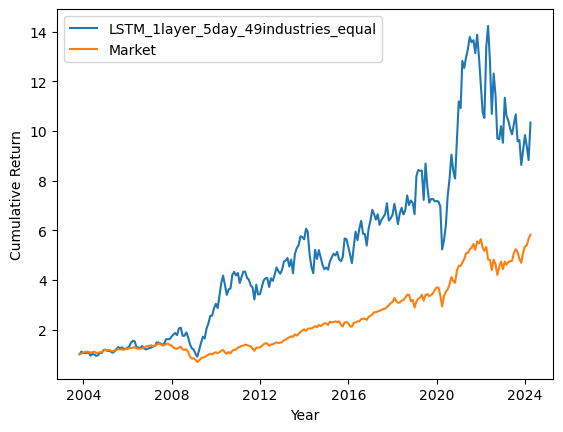

In [192]:
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/LSTM_1layer_5day_10epochs_49industries_value.pt', all_data_paths['49industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='LSTM_1layer_5day_10epochs_49industries_value', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM(f'models/LSTM_1layer_5day_49industries_value.pt', all_data_paths[f'49industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'LSTM_1layer_5day_49industries_value', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM(f'models/LSTM_1layer_5day_49industries_equal.pt', all_data_paths[f'49industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'LSTM_1layer_5day_49industries_equal', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM(f'models/LSTM_1layer_5day_49industries_equal.pt', all_data_paths[f'49industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'LSTM_1layer_5day_49industries_equal', log_scale=False)

15285 15285
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     160.1
Date:                Wed, 29 May 2024   Prob (F-statistic):           2.28e-96
Time:                        02:06:29   Log-Likelihood:                -3717.7
No. Observations:                3057   AIC:                             7443.
Df Residuals:                    3053   BIC:                             7468.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.015      2.

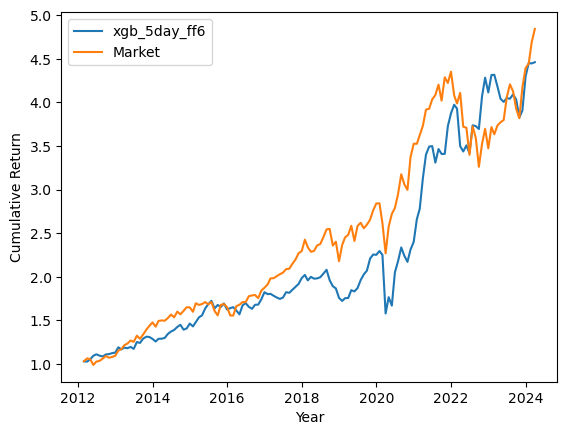

In [103]:
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb('models/xgb_5day_ff6.pt', all_data_paths['ff6'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='xgb_5day_ff6', log_scale=False)

25705 25705
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     3405.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        02:06:30   Log-Likelihood:                -6420.2
No. Observations:                5141   AIC:                         1.285e+04
Df Residuals:                    5137   BIC:                         1.287e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0303      0.012      2.

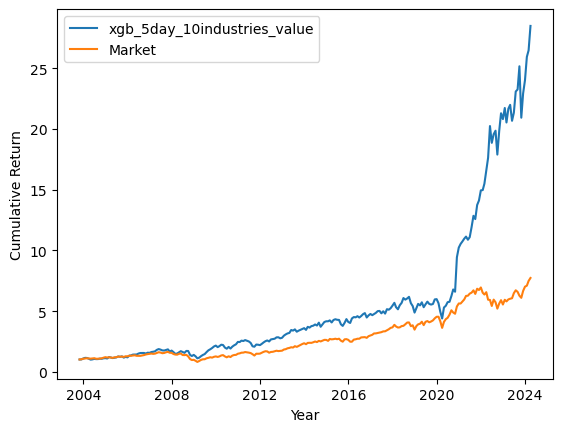

25705 25705
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     3367.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        02:06:30   Log-Likelihood:                -7053.2
No. Observations:                5141   AIC:                         1.411e+04
Df Residuals:                    5137   BIC:                         1.414e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0310      0.013      2.

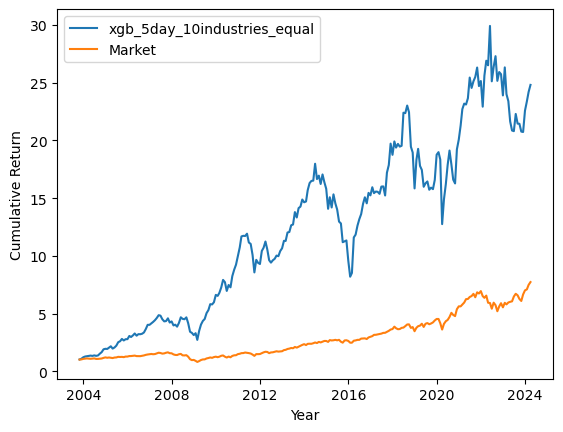

In [104]:
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb(f'models/xgb_5day_10industries_value.pt', all_data_paths[f'10industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'xgb_5day_10industries_value', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_xgb(f'models/xgb_5day_10industries_equal.pt', all_data_paths[f'10industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'xgb_5day_10industries_equal', log_scale=False)

25705 25705
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     1312.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        02:06:31   Log-Likelihood:                -9027.3
No. Observations:                5141   AIC:                         1.806e+04
Df Residuals:                    5137   BIC:                         1.809e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0316      0.020     -1.

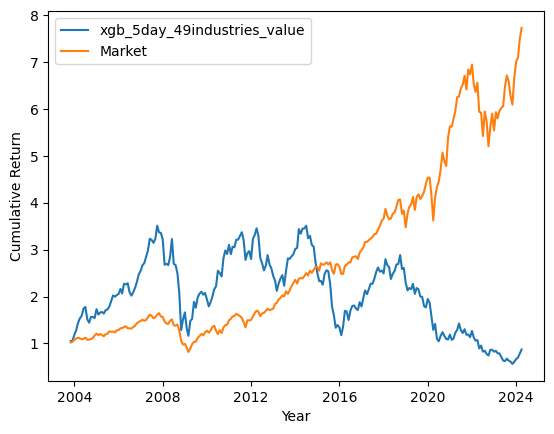

25705 25705
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     1012.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        02:06:32   Log-Likelihood:                -10057.
No. Observations:                5141   AIC:                         2.012e+04
Df Residuals:                    5137   BIC:                         2.015e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.024     -0.

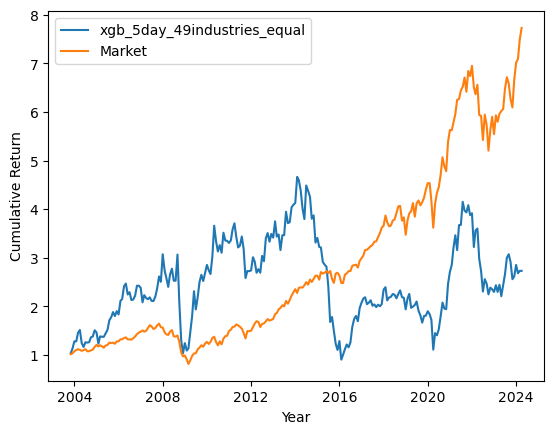

In [105]:
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb(f'models/xgb_5day_49industries_value.pt', all_data_paths[f'49industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='xgb_5day_49industries_value', log_scale=False)

strat_ret_vec, mkt_ret_vec = evaluate_model_xgb(f'models/xgb_5day_49industries_equal.pt', all_data_paths[f'49industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='xgb_5day_49industries_equal', log_scale=False)